In [1]:
import os 

os.environ["ISISROOT"] = "/usgs/pkgs/isis3.7.0/install

import pysis
from pysis import isis
from pysis.exceptions import ProcessError


import knoten
from knoten import vis

import json

import ale
from ale import util
from ale.drivers.lro_drivers import LroLrocPds3LabelNaifSpiceDriver
from ale.formatters.usgscsm_formatter import to_usgscsm

from IPython.display import Image

import plotly
plotly.offline.init_notebook_mode(connected=True)

/home/kberry/anaconda3/envs/knoten/lib/python3.7/site-packages/ale/__init__.py:22: UserWarning:

ALESPICEROOT environment variable not set, Spice Drivers will not function correctly



In [2]:
url = 'https://pdsimage2.wr.usgs.gov/Missions/Lunar_Reconnaissance_Orbiter/LROC/EDR/LROLRC_0018/DATA/EXT/2013354/NAC/M1142142198RE.IMG'

!wget -N -P data/ {url}
fileName = 'data/' + os.path.split(url)[1]

--2019-11-01 14:40:04--  https://pdsimage2.wr.usgs.gov/Missions/Lunar_Reconnaissance_Orbiter/LROC/EDR/LROLRC_0018/DATA/EXT/2013354/NAC/M1142142198RE.IMG
Resolving pdsimage2.wr.usgs.gov (pdsimage2.wr.usgs.gov)... 8.27.177.76, 2001:1900:2200:19ff::76
Connecting to pdsimage2.wr.usgs.gov (pdsimage2.wr.usgs.gov)|8.27.177.76|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘data/M1142142198RE.IMG’ not modified on server. Omitting download.



In [3]:
fileName = 'data/M1142142198RE.IMG'

In [4]:
# Set the output location of the resulting .cub
cub_loc = os.path.splitext(fileName)[0] + '.cub'

try: 
   isis.lronac2isis(from_=fileName, to=cub_loc)
except ProcessError as e:
   print(e.stderr)

try:
    isis.spiceinit(from_=cub_loc, shape='ellipsoid')
except ProcessError as e:
    print(e.stderr)

kernels = ale.util.generate_kernels_from_cube(cub_loc, expand=True)

usgscsm_str = ale.loads(fileName, props={'kernels': kernels}, formatter="usgscsm", verbose=False)

csm_isd = os.path.splitext(fileName)[0] + '.json'
with open(csm_isd, 'w') as isd_file:
    isd_file.write(usgscsm_str)

In [5]:
csmisis_diff_lv_plot, csmisis_diff_ephem_plot, external_orientation_data = vis.external_orientation_diff(csm_isd, cub_loc, 10, 50, 600, 600)

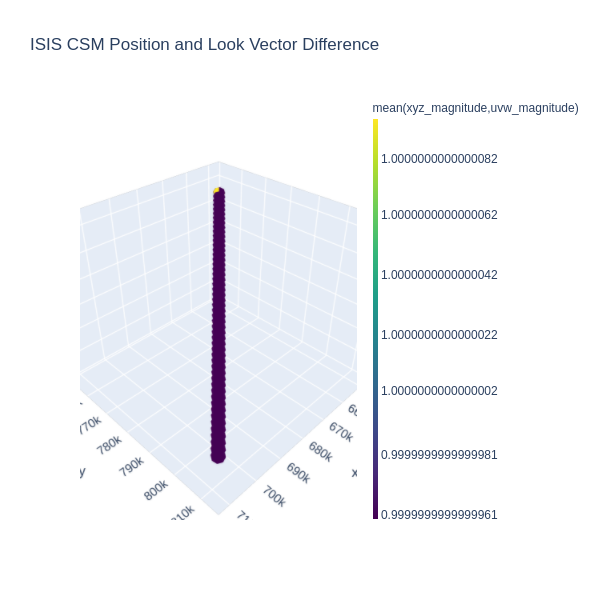

In [6]:
csmisis_diff_lv_plot_bytes = csmisis_diff_lv_plot.to_image(format="png")
csmisis_diff_ephem_plot_bytes = csmisis_diff_ephem_plot.to_image(format="png")
Image(csmisis_diff_lv_plot_bytes)


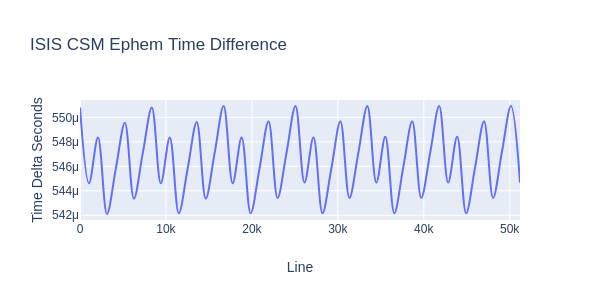

In [7]:
Image(csmisis_diff_ephem_plot_bytes)

In [8]:
external_orientation_data[['diffx', 'diffy', 'diffz', 'diffu', 'diffv', 'diffw']].describe()

,diffx,diffy,diffz,diffu,diffv,diffw
count,500.000000,500.000000,500.000000,5.000000e+02,5.000000e+02,5.000000e+02
mean,-0.513109,-0.493670,0.489987,2.702404e-07,2.698949e-07,-2.483218e-07
std,0.004336,0.004903,0.010050,7.420841e-08,7.596163e-08,3.829392e-08
min,-0.520359,-0.501884,0.472858,6.335759e-08,1.124616e-07,-4.123344e-07
25%,-0.516904,-0.497954,0.481328,2.478083e-07,2.382711e-07,-2.566595e-07
50%,-0.513161,-0.493720,0.490028,2.774823e-07,2.700087e-07,-2.460021e-07
75%,-0.509340,-0.489412,0.498665,3.093850e-07,3.013724e-07,-2.276752e-07
max,-0.505680,-0.485284,0.506943,4.496840e-07,5.071432e-07,-1.797020e-07


In [9]:
isis2csm_plot, csm2isis_plot, isiscsm_plotlatlon, isiscsm_plotbf, isis2csm_data, csm2isis_data, isiscsm_latlondata, isiscsm_bfdata = vis.reprojection_diff(csm_isd, cub_loc, 10, 50, 500, 500, 0.1)

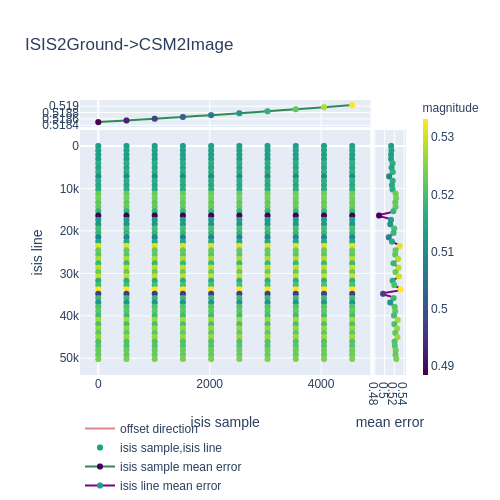

In [10]:
Image(isis2csm_plot.to_image())

In [11]:
isis2csm_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,500.000000,500.000000
mean,0.518678,-0.000014
std,0.007601,0.008934
min,0.488284,-0.025600
25%,0.514866,-0.004389
50%,0.519770,-0.000230
75%,0.522565,0.004317
max,0.533111,0.024682


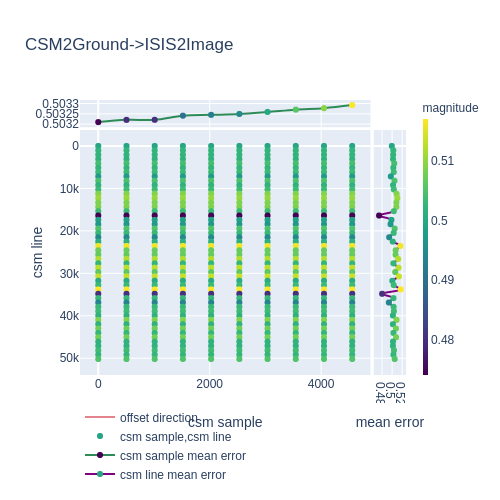

In [12]:
Image(csm2isis_plot.to_image())

In [13]:
csm2isis_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,500.000000,500.000000
mean,-0.503169,-0.000615
std,0.007186,0.008985
min,-0.517027,-0.024916
25%,-0.506983,-0.005174
50%,-0.503075,-0.000123
75%,-0.501653,0.004092
max,-0.473941,0.025033


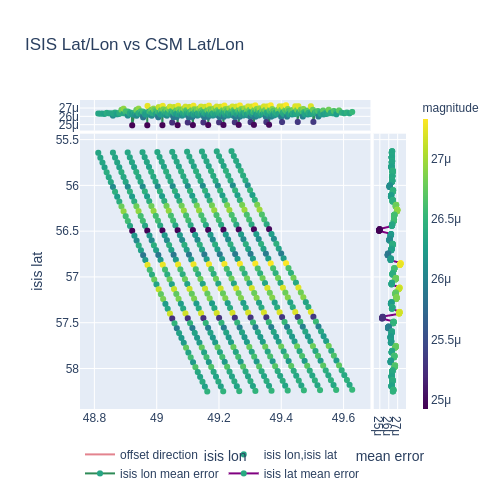

In [14]:
Image(isiscsm_plotlatlon.to_image())

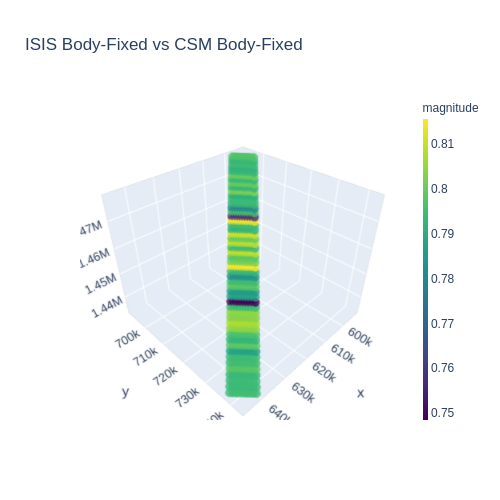

In [15]:
Image(isiscsm_plotbf.to_image())

In [16]:
isiscsm_bfdata[['diffx', 'diffy', 'diffz']].describe()

,diffx,diffy,diffz
count,500.000000,500.000000,500.000000
mean,-0.751932,0.462217,-0.432212
std,0.018396,0.013145,0.010877
min,-0.782673,0.420969,-0.447381
25%,-0.769789,0.453996,-0.442947
50%,-0.748952,0.462659,-0.434219
75%,-0.736401,0.470221,-0.424239
max,-0.710516,0.493445,-0.404723
